# Quick Tiny-ImageNet OptiRoulette Demo

Demo notebook for the OptiRoulette package using fixed defaults and no CLI args.

- Uses hardcoded settings aligned with `config/samix_improved_tiny_imagenet.yaml` (no config file loading).
- Uses `samix` architecture (`ResNeXt50` with Tiny-ImageNet stem adjustments).
- Downloads and prepares Tiny-ImageNet automatically into `data/tiny-imagenet-200`.
- Keeps OptiRoulette package defaults where they already match the profile.
- Demo defaults: `epochs=100`, `batch_size=128`, `seed=2131855840`.


In [3]:
import importlib
import os
import random
import shutil
import subprocess
import sys
import urllib.request
import zipfile
from typing import Any, Dict, Optional

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from torchvision.models import resnext50_32x4d
from torchvision.transforms import InterpolationMode


def _pip_install(*packages: str) -> None:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *packages])


try:
    import yaml  # noqa: F401
except ModuleNotFoundError:
    _pip_install('pyyaml')


try:
    import optiroulette  # noqa: F401
except ModuleNotFoundError:
    _pip_install('OptiRoulette')


try:
    import pytorch_optimizer  # noqa: F401
except ModuleNotFoundError:
    _pip_install('pytorch-optimizer')


import optiroulette
import optiroulette.optimizer_factory as _opt_factory
importlib.reload(_opt_factory)
from optiroulette import OptiRoulette

print(f'PyTorch: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')


PyTorch: 2.4.1+cu121
CUDA available: True


In [ ]:
seed = 2131855840
data_dir = 'data/tiny-imagenet-200'
epochs = 100
batch_size = 128
num_workers = 4
val_split_enabled = True
train_ratio = 0.9
split_seed = 42

model_architecture = 'samix'
num_classes = 200
samix_enabled = False  

label_smoothing = 0.0
grad_clip = 2.0
use_mixed_precision = True

tiny_mean = [0.480, 0.448, 0.398]
tiny_std = [0.277, 0.269, 0.282]
ra_num_ops = 2
ra_magnitude = 9
random_erasing_p = 0.25
random_erasing_scale = (0.02, 0.1)
random_erasing_ratio = (0.3, 3.3)


In [6]:
TINY_IMAGENET_URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def configure_torch(deterministic: bool = False, benchmark: bool = True) -> None:
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)
    else:
        torch.backends.cudnn.benchmark = bool(benchmark)


def _organize_train(root: str) -> None:
    train_dir = os.path.join(root, 'train')
    for cls in os.listdir(train_dir):
        cls_dir = os.path.join(train_dir, cls)
        images_dir = os.path.join(cls_dir, 'images')
        if os.path.isdir(images_dir):
            for img in os.listdir(images_dir):
                shutil.move(os.path.join(images_dir, img), os.path.join(cls_dir, img))
            shutil.rmtree(images_dir)
        boxes = os.path.join(cls_dir, 'boxes.txt')
        if os.path.exists(boxes):
            os.remove(boxes)


def _organize_val(root: str) -> None:
    val_dir = os.path.join(root, 'val')
    annotations = os.path.join(val_dir, 'val_annotations.txt')
    images_dir = os.path.join(val_dir, 'images')
    if not os.path.exists(annotations):
        return
    with open(annotations, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            img, cls = parts[0], parts[1]
            cls_dir = os.path.join(val_dir, cls)
            os.makedirs(cls_dir, exist_ok=True)
            shutil.move(os.path.join(images_dir, img), os.path.join(cls_dir, img))
    os.remove(annotations)
    shutil.rmtree(images_dir)


def download_and_prepare_tiny_imagenet(root: str) -> None:
    os.makedirs(root, exist_ok=True)
    if os.path.exists(os.path.join(root, 'train')) and os.path.exists(os.path.join(root, 'val')):
        print(f'Tiny-ImageNet already prepared at: {root}')
        return

    zip_path = os.path.join(root, 'tiny-imagenet-200.zip')
    print(f'Downloading Tiny-ImageNet to {zip_path} ...')
    urllib.request.urlretrieve(TINY_IMAGENET_URL, zip_path)

    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(root)
    os.remove(zip_path)

    extracted_dir = os.path.join(root, 'tiny-imagenet-200')
    for name in os.listdir(extracted_dir):
        shutil.move(os.path.join(extracted_dir, name), root)
    shutil.rmtree(extracted_dir)

    _organize_train(root)
    _organize_val(root)
    print(f'Tiny-ImageNet ready at: {root}')


def build_transforms(train: bool) -> transforms.Compose:
    target = 64
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop(target, scale=(0.6, 1.0), interpolation=InterpolationMode.BICUBIC),
            transforms.RandAugment(num_ops=ra_num_ops, magnitude=ra_magnitude),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(tiny_mean, tiny_std),
            transforms.RandomErasing(p=random_erasing_p, scale=random_erasing_scale, ratio=random_erasing_ratio),
        ])

    return transforms.Compose([
        transforms.Resize(72, interpolation=InterpolationMode.BICUBIC, antialias=True),
        transforms.CenterCrop(target),
        transforms.ToTensor(),
        transforms.Normalize(tiny_mean, tiny_std),
    ])


def build_dataloaders(
    root: str,
    batch_size: int,
    num_workers: int,
    use_val_split: bool,
    train_ratio: float,
    split_seed: int,
) -> Dict[str, DataLoader]:
    train_tf = build_transforms(train=True)
    eval_tf = build_transforms(train=False)

    full_train = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_tf)
    test_set = datasets.ImageFolder(os.path.join(root, 'val'), transform=eval_tf)

    if use_val_split:
        total_size = len(full_train)
        train_size = int(total_size * train_ratio)
        val_size = total_size - train_size
        generator = torch.Generator().manual_seed(split_seed)
        train_subset, val_subset = random_split(full_train, [train_size, val_size], generator=generator)

        val_full = datasets.ImageFolder(os.path.join(root, 'train'), transform=eval_tf)
        val_set = Subset(val_full, val_subset.indices)
    else:
        train_subset = full_train
        val_set = test_set

    persistent = num_workers > 0
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        persistent_workers=persistent,
    )
    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
        persistent_workers=persistent,
    )
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
        persistent_workers=persistent,
    )

    print('Train/Val/Test sizes:')
    print(f'  Train: {len(train_loader.dataset)}')
    print(f'  Val:   {len(val_loader.dataset)}')
    print(f'  Test:  {len(test_loader.dataset)}')

    return {'train': train_loader, 'val': val_loader, 'test': test_loader}


def create_model(architecture: str, num_classes: int) -> nn.Module:
    if architecture in {'samix', 'imagenet_samix'}:
        model = resnext50_32x4d(weights=None)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    raise ValueError(f'Unsupported architecture for this notebook: {architecture}')


In [8]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: OptiRoulette,
    criterion: nn.Module,
    device: torch.device,
    scaler: Optional[torch.amp.GradScaler],
    grad_clip: float,
) -> Dict[str, float]:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(loader):
        optimizer.on_batch_start(batch_idx)
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        active_cls_name = optimizer.active_optimizer.__class__.__name__.lower()
        is_sam = active_cls_name == 'sam'
        requires_second_order = active_cls_name == 'adahessian'
        use_amp_batch = (scaler is not None) and (not is_sam) and (not requires_second_order)

        if is_sam:
            def closure():
                optimizer.zero_grad(set_to_none=True)
                outputs_inner = model(images)
                loss_inner = criterion(outputs_inner, labels)
                loss_inner.backward()
                if grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                return loss_inner

            loss = closure()
            optimizer.step(closure)
            with torch.no_grad():
                outputs = model(images)
        else:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device.type, enabled=use_amp_batch):
                outputs = model(images)
                loss = criterion(outputs, labels)

            if use_amp_batch:
                scaler.scale(loss).backward(create_graph=requires_second_order)
                if grad_clip > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward(create_graph=requires_second_order)
                if grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return {'loss': running_loss / max(total, 1), 'accuracy': correct / max(total, 1)}


@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Dict[str, float]:
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return {'loss': running_loss / max(total, 1), 'accuracy': correct / max(total, 1)}


In [9]:
set_seed(seed)
configure_torch(deterministic=False, benchmark=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = torch.amp.GradScaler('cuda') if (use_mixed_precision and device.type == 'cuda') else None

download_and_prepare_tiny_imagenet(data_dir)
loaders = build_dataloaders(
    root=data_dir,
    batch_size=batch_size,
    num_workers=num_workers,
    use_val_split=val_split_enabled,
    train_ratio=train_ratio,
    split_seed=split_seed,
)

model = create_model(model_architecture, num_classes=num_classes).to(device)

# Package defaults for optimizer/pool logic
optimizer = OptiRoulette(model.parameters(), seed=seed)
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

print('Starting OptiRoulette Tiny-ImageNet training (samix_improved profile)')
print(f'Device: {device}')
print(f'Architecture: {model_architecture} (samix.enabled={samix_enabled})')
print(f'Epochs: {epochs} | Batch size: {batch_size}')
print(f'Grad clip: {grad_clip} | Mixed precision: {use_mixed_precision}')
print(
    'Switch: '
    f"{getattr(optimizer, 'switch_granularity', 'epoch')} | "
    f"Avoid repeat: {getattr(optimizer, 'avoid_repeat', True)}"
)
if getattr(optimizer, '_warmup_enabled', False):
    print(
        f"Warmup: epochs={getattr(optimizer, 'warmup_epochs', 0)} "
        f"optimizer={getattr(optimizer, 'warmup_optimizer', None)} "
        f"plateau={bool(getattr(optimizer, 'warmup_config', None))} "
        f"drop_after={getattr(optimizer, 'drop_after_warmup', False)}"
    )


Tiny-ImageNet already prepared at: data/tiny-imagenet-200
Train/Val/Test sizes:
  Train: 90000
  Val:   10000
  Test:  10000
Starting OptiRoulette Tiny-ImageNet training (samix_improved profile)
Device: cuda
Architecture: samix (samix.enabled=False)
Epochs: 100 | Batch size: 128
Grad clip: 2.0 | Mixed precision: True
Switch: epoch | Avoid repeat: True
Warmup: epochs=17 optimizer=sgd plateau=True drop_after=True


In [10]:
history = []

for epoch in range(epochs):
    optimizer.reset_epoch_stats()
    optimizer.on_epoch_start(epoch)
    active_name = optimizer.active_optimizer_name

    train_metrics = train_one_epoch(
        model,
        loaders['train'],
        optimizer,
        criterion,
        device,
        scaler,
        grad_clip,
    )
    val_metrics = evaluate(model, loaders['val'], criterion, device)
    selection_counts = optimizer.get_epoch_selection_counts()

    history.append({
        'epoch': epoch + 1,
        'active': active_name,
        'train_loss': train_metrics['loss'],
        'train_acc': train_metrics['accuracy'],
        'val_loss': val_metrics['loss'],
        'val_acc': val_metrics['accuracy'],
        'selections': selection_counts,
    })

    print(
        f"Epoch {epoch + 1:03d} | {active_name.upper()} | "
        f"Train Loss {train_metrics['loss']:.4f} Acc {train_metrics['accuracy']:.4f} | "
        f"Val Loss {val_metrics['loss']:.4f} Val Acc {val_metrics['accuracy']:.4f} | "
        f"Selections {selection_counts}",
        flush=True,
    )
    optimizer.on_epoch_end(val_acc=val_metrics['accuracy'])

test_metrics = evaluate(model, loaders['test'], criterion, device)
print(f"Test Loss {test_metrics['loss']:.4f} | Test Acc {test_metrics['accuracy']:.4f}")


Epoch 001 | SGD | Train Loss 5.0157 Acc 0.0284 | Val Loss 4.6284 Val Acc 0.0580 | Selections {'adam': 0, 'adamw': 0, 'sgd': 703, 'nadam': 0, 'Adagrad': 0, 'amsgrad': 0, 'adabelief': 0, 'yogi': 0, 'qhadam': 0, 'adamp': 0, 'novograd': 0, 'lion': 0, 'ranger': 0, 'ranger21': 0, 'adan': 0, 'AdaHessian': 0, 'rmsprop': 0, 'radam': 0, 'adai': 0, 'gravity': 0, 'TAM': 0, 'SPlus': 0, 'Fromage': 0, 'AggMo': 0, 'GaLore': 0, 'ADOPT': 0, 'fira': 0, 'Apollo': 0, 'AccSGD': 0, 'PID': 0, 'ASGD': 0, 'SGDW': 0, 'AdaNorm': 0, 'Nero': 0}
Epoch 002 | SGD | Train Loss 4.2081 Acc 0.1037 | Val Loss 3.8700 Val Acc 0.1560 | Selections {'adam': 0, 'adamw': 0, 'sgd': 703, 'nadam': 0, 'Adagrad': 0, 'amsgrad': 0, 'adabelief': 0, 'yogi': 0, 'qhadam': 0, 'adamp': 0, 'novograd': 0, 'lion': 0, 'ranger': 0, 'ranger21': 0, 'adan': 0, 'AdaHessian': 0, 'rmsprop': 0, 'radam': 0, 'adai': 0, 'gravity': 0, 'TAM': 0, 'SPlus': 0, 'Fromage': 0, 'AggMo': 0, 'GaLore': 0, 'ADOPT': 0, 'fira': 0, 'Apollo': 0, 'AccSGD': 0, 'PID': 0, 'ASGD

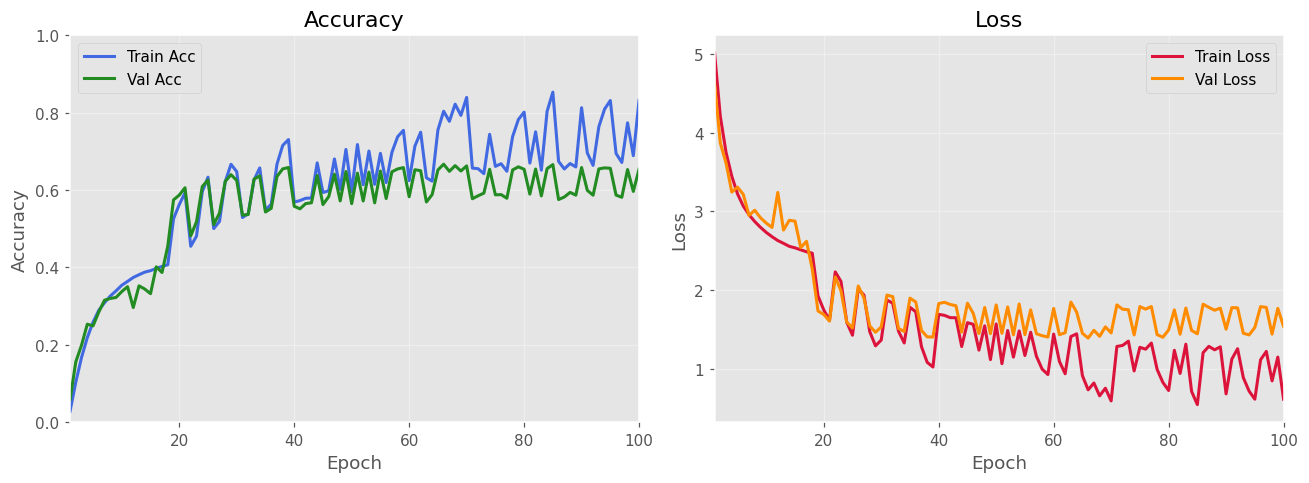

In [11]:
# Accuracy/Loss plots
if not history:
    print('No training history found. Run the training cell first.')
else:
    epochs_axis = [h['epoch'] for h in history]
    train_acc = [h['train_acc'] for h in history]
    val_acc = [h['val_acc'] for h in history]
    train_loss = [h['train_loss'] for h in history]
    val_loss = [h['val_loss'] for h in history]

    plt.style.use('ggplot')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), dpi=110)

    ax = axes[0]
    ax.plot(epochs_axis, train_acc, color='royalblue', linewidth=2, label='Train Acc')
    ax.plot(epochs_axis, val_acc, color='forestgreen', linewidth=2, label='Val Acc')
    ax.set_title('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(1, max(epochs_axis))
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, alpha=0.35)
    ax.legend(loc='best')

    ax = axes[1]
    ax.plot(epochs_axis, train_loss, color='crimson', linewidth=2, label='Train Loss')
    ax.plot(epochs_axis, val_loss, color='darkorange', linewidth=2, label='Val Loss')
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_xlim(1, max(epochs_axis))
    ax.grid(True, alpha=0.35)
    ax.legend(loc='best')

    fig.tight_layout()
    plt.show()
